In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


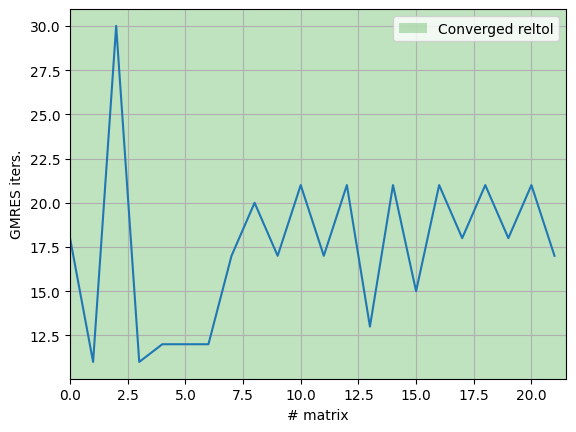

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

21

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 48
sliding = 0
open = 24
transition = 72
total = 72


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.22


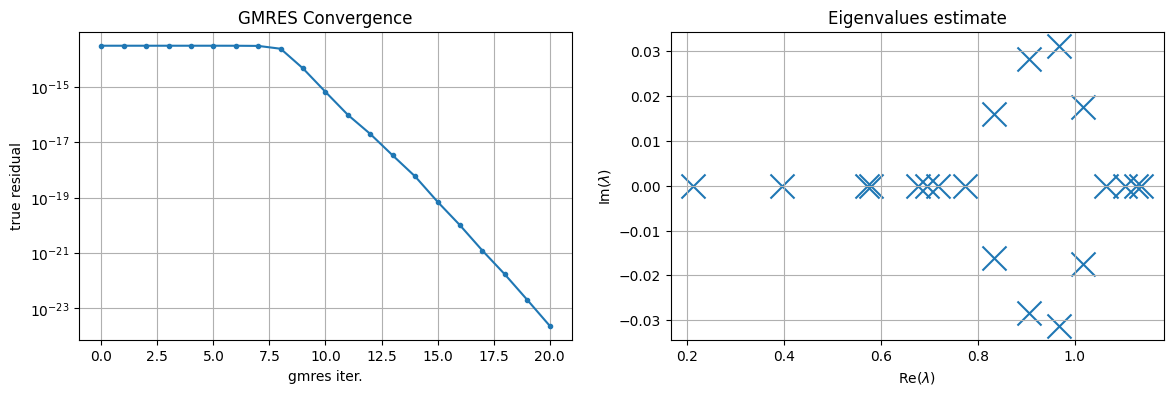

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

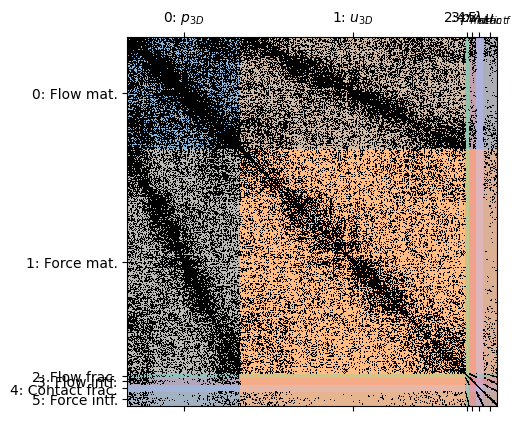

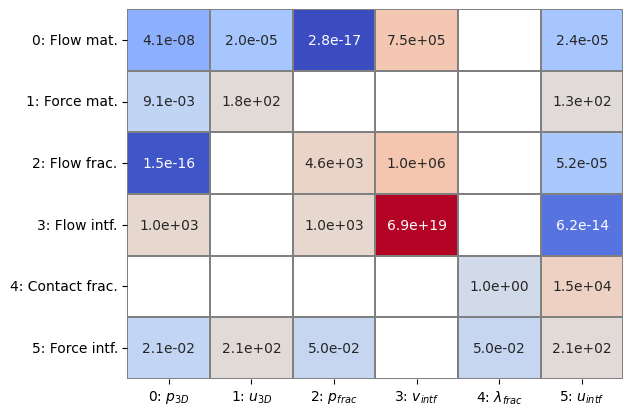

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

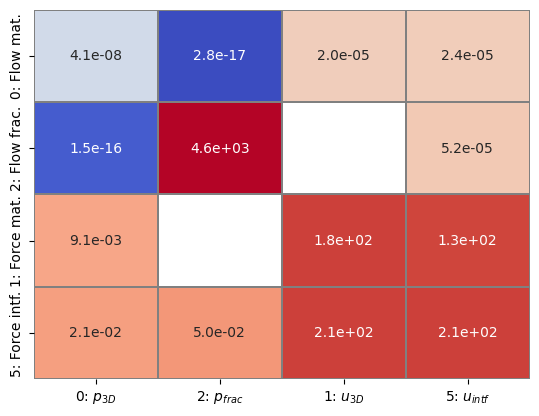

In [48]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: extract_diag_inv(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
        complement=SolveSchema(groups=[0, 2, 1, 5], solve=lambda bmat: bmat.mat),
    ),
)

mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
mat_permuted[[0, 2, 1, 5]].plot_max()

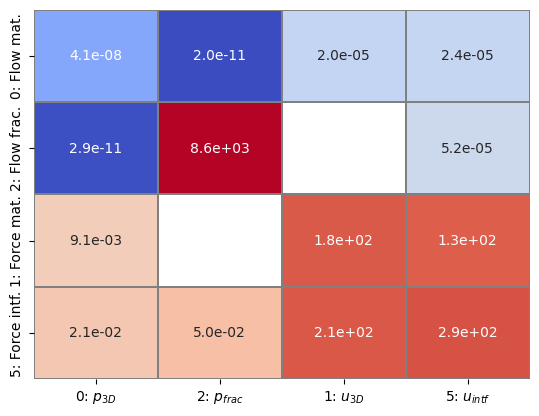

In [47]:
tmp = J[[0, 2, 1, 5]]
tmp.mat = prec.S11_inv.S11_inv
tmp.plot_max()

Solve  took: 0.06


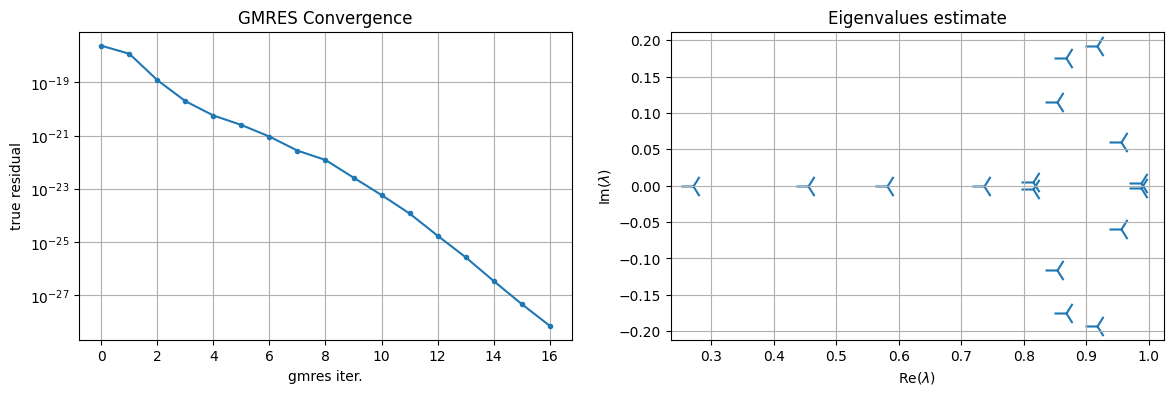

In [49]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv, make_J44_inv_bdiag

schema15_amg = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
    complement=schema15_amg,
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.47
PETSc Converged Reason: -5
lambda min: 0.21581351319444483


Text(0.5, 1.0, 'Eigenvalues estimate')

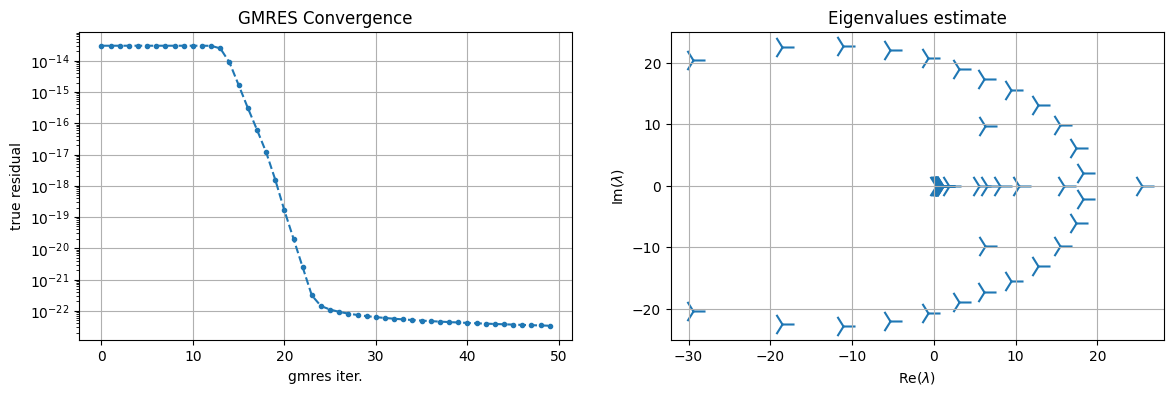

In [50]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    # solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.subplot(1, 2, 1).set_title('GMRES Convergence')
plt.subplot(1, 2, 2).set_title('Eigenvalues estimate')

# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

# MAKING NEW FIXED STRESS

array([0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.00010001, 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.00010001, 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    , 0.0001    , 0.0001    , 0.0001    ,
       0.0001    , 0.0001    ])

In [54]:
fractures = model.mdg.subdomains(dim=1)


0.4559

/home/porepy/simulations/plot_utils.py:103: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


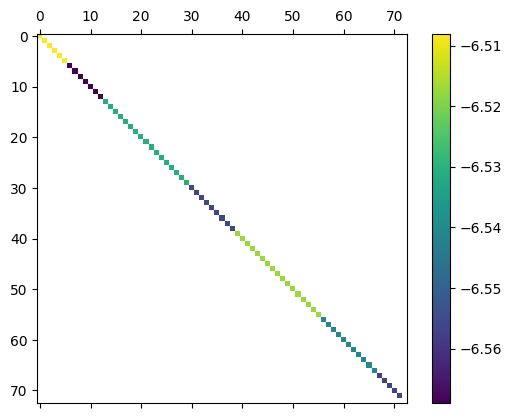

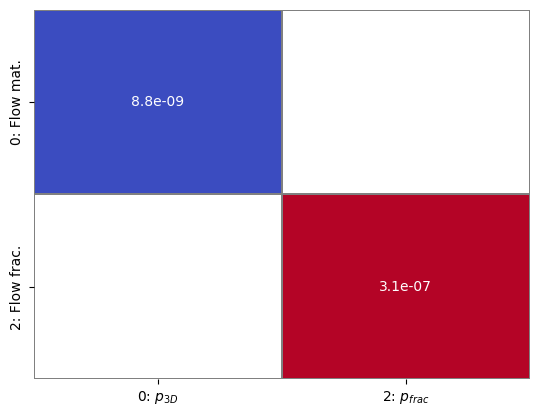

In [51]:
import scipy.sparse


def make_S22_bdiag(model, bmat: BlockMatrixStorage):
    # This one works

    mu_lame = model.solid.shear_modulus()
    lambda_lame = model.solid.lame_lambda()
    alpha_biot = model.solid.biot_coefficient()
    l_factor = 0.6
    dt = model.time_manager.dt
    max_dim = model.nd

    l_phys = alpha_biot**2 / (2 * mu_lame / max_dim + lambda_lame)
    l_min = alpha_biot**2 / (4 * mu_lame + 2 * lambda_lame)
    val = l_min * (l_phys / l_min) ** l_factor

    fixed_stress_2d = []

    fractures = model.mdg.subdomains(dim=1)

    # new
    a = model.aperture(fractures).value(model.equation_system)
    model.fluid.compressibility()
    # new
    
    fixed_stress_1d = val

    cell_volumes = np.concatenate([sd.cell_volumes for sd in fractures])
    fixed_stress_1d *= cell_volumes

    density = model.fluid_density(fractures).value(model.equation_system)
    fixed_stress_1d *= density
    fixed_stress_1d /= dt

    # sticking = get_sticking(data, idx=mat_idx)
    # fixed_stress_1d[sticking] = 0

    # fixed_stress_1d *= 0
    # fixed_stress_1d *= -1

    fixed_stress_0d = np.zeros(sum(sd.num_cells for sd in model.mdg.subdomains(dim=0)))

    fixed_stress = np.concatenate([fixed_stress_2d, fixed_stress_1d, fixed_stress_0d])

    result = scipy.sparse.diags(fixed_stress).tocsr()
    plot_mat(result)
    return result

def get_fixed_stress_stabilization_nd_new(model, bmat):
    matrix = get_fixed_stress_stabilization(model)
    frac = make_S22_bdiag(model, bmat)
    return scipy.sparse.block_diag([matrix, frac], format='csr')

tmp = J[[0,2]]
tmp.mat = get_fixed_stress_stabilization_nd_new(model, J)
tmp.plot_max()

/home/porepy/simulations/plot_utils.py:103: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


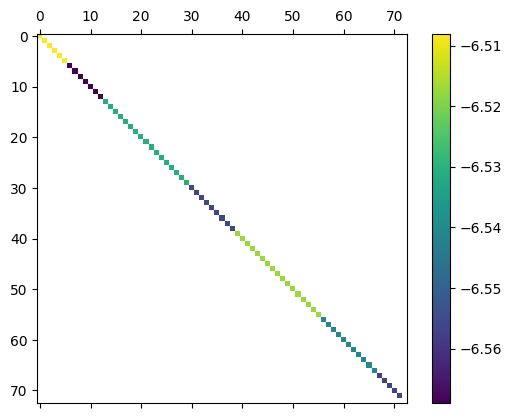

Solve  took: 0.17


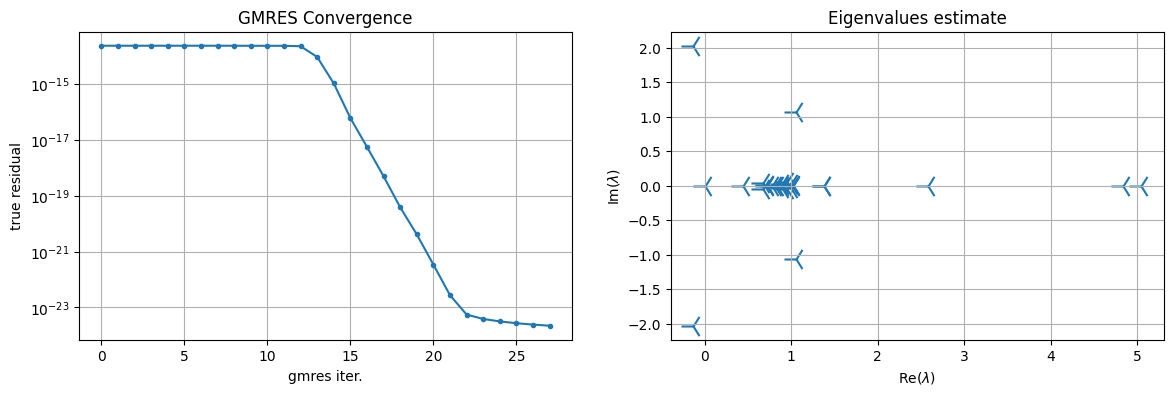

In [15]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor_type="physical",
    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
    # invertor=lambda bmat: get_new_fixed_stress_stabilization_nd(model, bmat=bmat),
    invertor=lambda bmat: make_S22_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

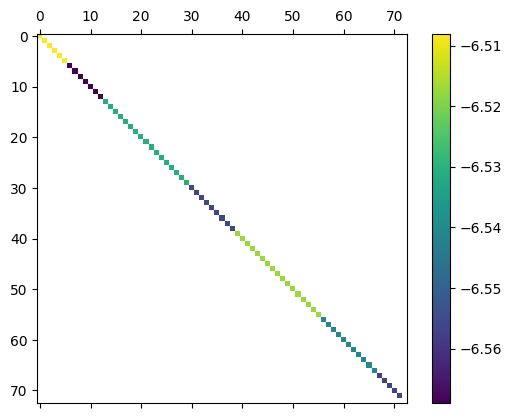

Solve  took: 0.37


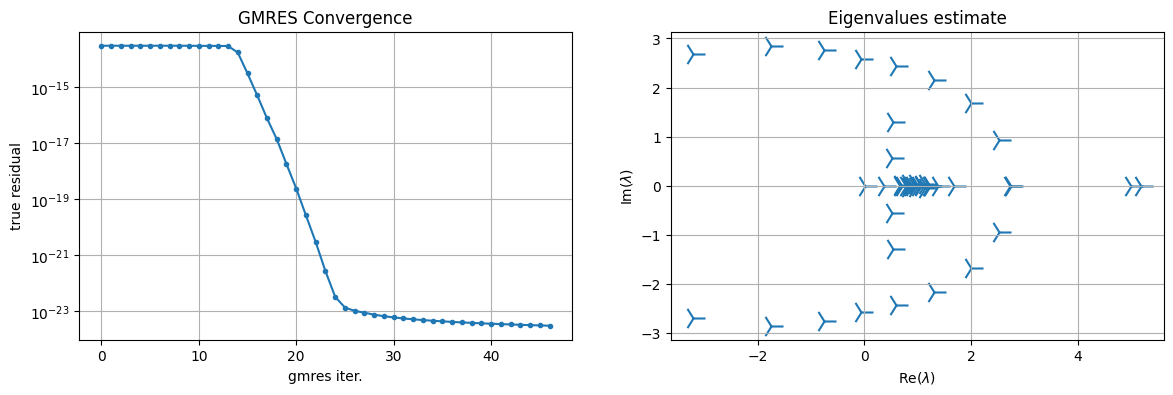

In [16]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor_type="physical",
    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
    invertor=lambda bmat: get_fixed_stress_stabilization_nd_new(model, bmat),
    # invertor=lambda bmat: make_S22_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

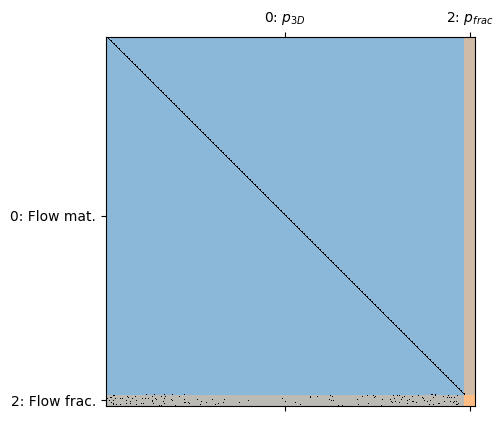

In [17]:
def get_fixed_stress_stabilization_nd_new(model, bmat):
    mu_lame = model.solid.shear_modulus()
    lambda_lame = model.solid.lame_lambda()
    # alpha_biot = model.solid.biot_coefficient()
    nd = model.nd

    K = 2 * mu_lame / nd + lambda_lame

    matrix = model.mdg.subdomains(dim=2)[0]
    fractures = model.mdg.subdomains(dim=1)

    faces_to_cells = matrix.cell_faces.T.tocsc()
    faces_to_cells.eliminate_zeros()

    dt = model.time_manager.dt

    mat_list = []
    for frac in fractures:
        intfs = model.mdg.subdomain_to_interfaces(sd=frac)
        intf = intfs[0]
        assert all(intf.dim < frac.dim for intf in intfs[1:])

        secondary_to_mortar = intf.secondary_to_mortar_avg().tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg().tocsc()
        sign_to_mortar_side = intf.sign_of_mortar_sides().diagonal()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()

        frac_to_mat_cells = faces_to_cells @ mortar_to_primary

        h = matrix.cell_diameters()[frac_to_mat_cells.indices] / 2
        h = scipy.sparse.diags(h)

        dp_h = faces_to_cells @ mortar_to_primary @ h @ secondary_to_mortar

        rho_frac = model.fluid_density([frac]).value(model.equation_system)
        v_frac = frac.cell_volumes

        rho_v_frac = scipy.sparse.diags(rho_frac * v_frac)

        dp_h_rho_v = dp_h @ rho_v_frac

        mat_list.append(dp_h_rho_v)

    mat = scipy.sparse.bmat([mat_list], format="csr").T
    mat *= K / dt * (-1)

    block_00 = get_fixed_stress_stabilization(model)

    zeros = scipy.sparse.csr_matrix((mat.shape[0], mat.shape[0]))

    intersec_size = sum(sd.num_cells for sd in model.mdg.subdomains(dim=0))
    intersections = scipy.sparse.csr_matrix((intersec_size, intersec_size))

    return scipy.sparse.bmat(
        [
            [block_00, None, None],
            [mat, zeros, None],
            [None, None, intersections],
        ]
    )

tmp = J[[0, 2]]
tmp.mat = get_fixed_stress_stabilization_nd_new(model, J)
tmp.color_spy()

Solve  took: 1.26
PETSc Converged Reason: -5
lambda min: 0.13978887475224036


Text(0.5, 1.0, 'Eigenvalues estimate')

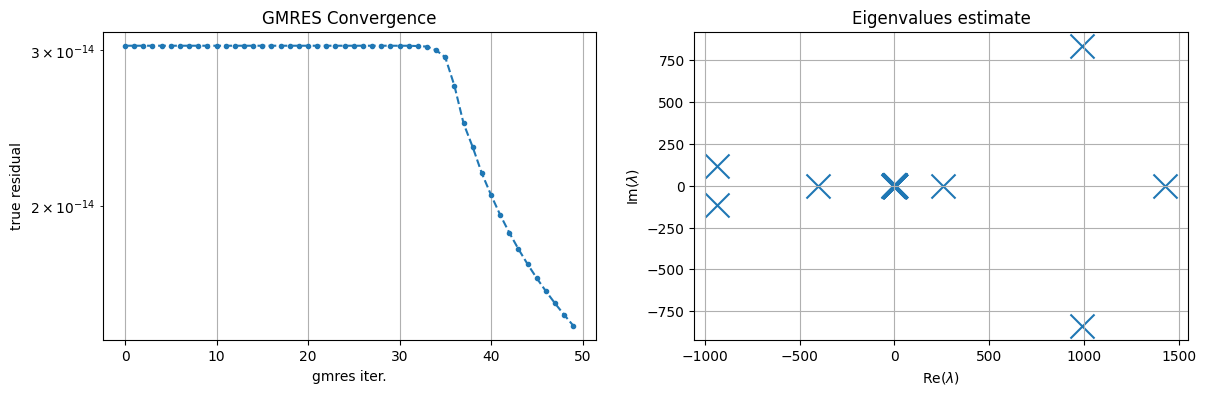

In [18]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv, make_J44_inv_bdiag


schema = SolveSchema(
    # groups=[3],
    # # solve=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # # solve=lambda bmat: PetscILU(bmat.mat),
    # only_complement=True,

    # complement=SolveSchema(
    #     groups=[4],
    #     solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
    #     only_complement=True,

    #     complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda bmat: get_fixed_stress_stabilization_nd_new(model, bmat),
            # only_complement=True,
            complement=SolveSchema(
                groups=[0, 2],
                # solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        # ),
    # ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.subplot(1, 2, 1).set_title('GMRES Convergence')
plt.subplot(1, 2, 2).set_title('Eigenvalues estimate')

# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

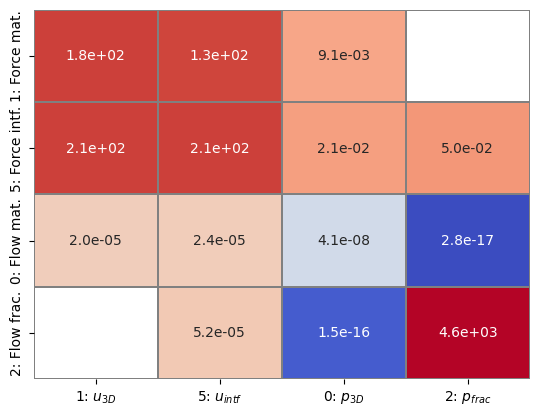

In [19]:
mat_permuted.plot_max()

In [20]:
def make_S22_bdiag(model, bmat: BlockMatrixStorage):
    elim = [1,5]
    keep = [0,2]

    # Jelim_bdiag_inv = inv_block_diag(bmat[elim, elim].mat, nd=model.nd)
    Jelim_bdiag_inv = inv(bmat[elim, elim].mat)
    Skeep = - bmat[keep, elim].mat @ Jelim_bdiag_inv @ bmat[elim, keep].mat
    
    return Skeep

tmp = J[[0,2]]
tmp.mat = make_S22_bdiag(model, J)
tmp.plot_max()

KeyboardInterrupt: 

In [ ]:
tmp[2,2].matshow(log=False)

In [ ]:
sticking, sliding, open_ = get_sticking_sliding_open(data, idx=mat_idx)
open_

[False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True]

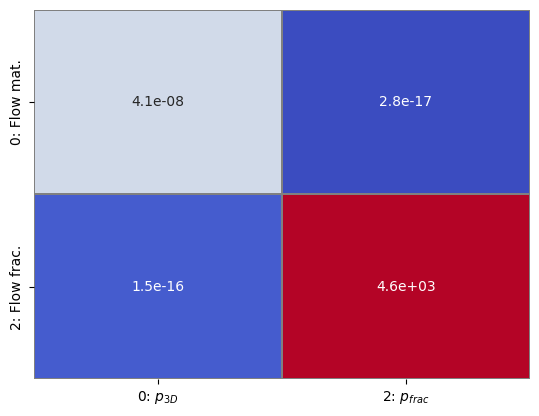

In [ ]:
J[[0,2]].plot_max()

Returning only Schur complement based on [0, 2]
Solve  took: 0.06


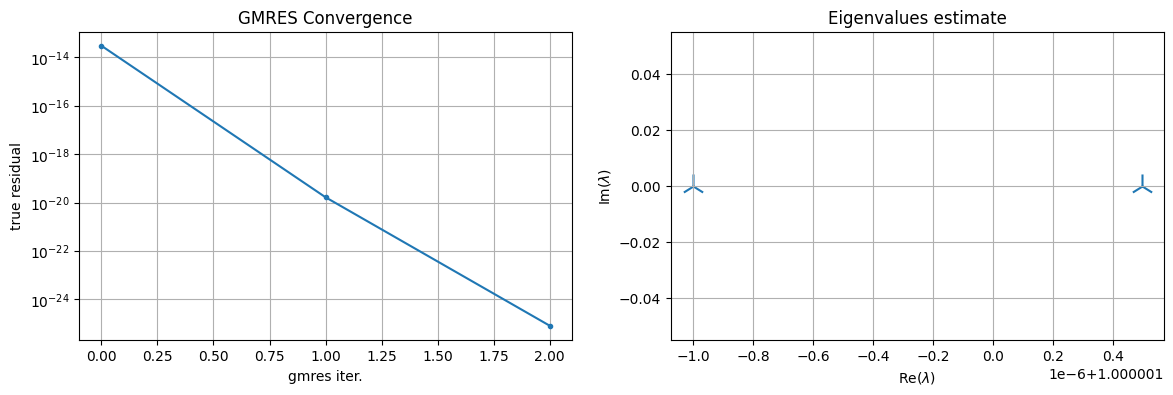

In [ ]:
schema = SolveSchema(
    groups=[1,5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor_type="physical",
    invertor=lambda bmat: make_S22_bdiag(model, bmat),
    only_complement=True,
    complement=SolveSchema(
        groups=[0,2],
        # solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

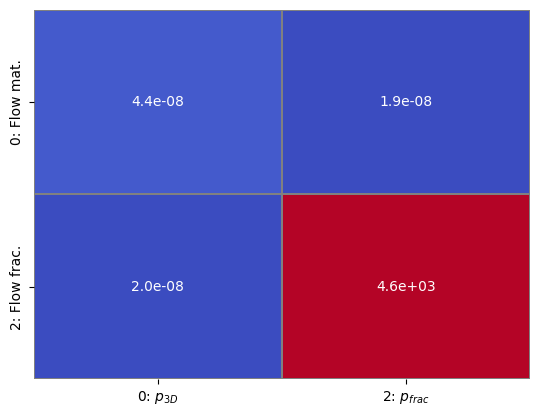

In [ ]:
mat_permuted.plot_max()

In [21]:
p_blocks = [0, 2]
u_blocks = [1, 5]

stab = -J[p_blocks, u_blocks].mat @ inv(J[u_blocks, u_blocks].mat) @ J[u_blocks, p_blocks].mat

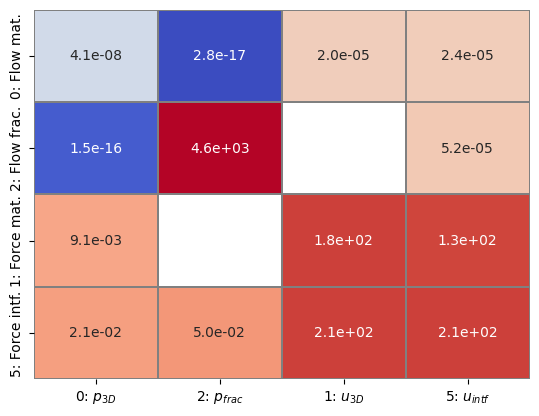

In [24]:
J[p_blocks + u_blocks].plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


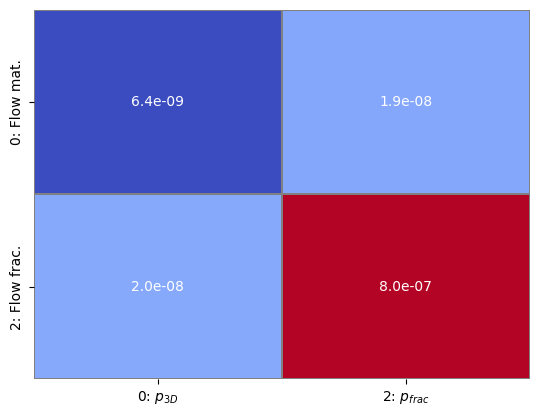

In [23]:
tmp = J[p_blocks, p_blocks].copy()
tmp[p_blocks, p_blocks] = stab
tmp.plot_max()

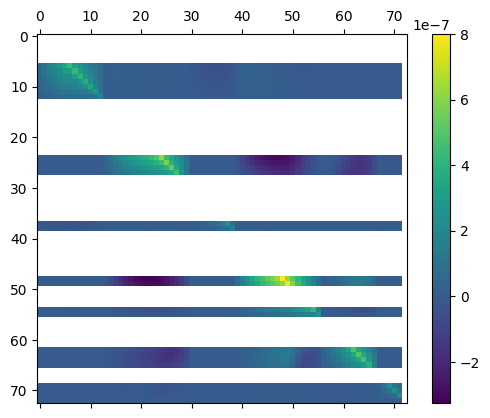

In [26]:
tmp[2, 2].matshow(log=False)

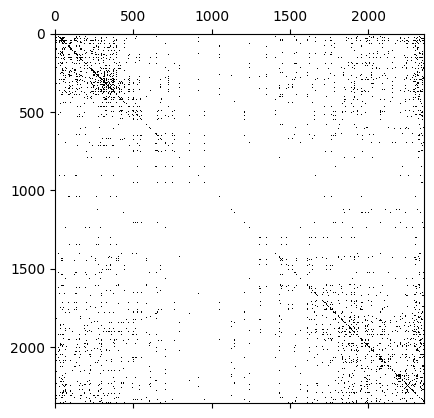

In [29]:
p_blocks = [0, 2]

stab = -J[p_blocks, 5].mat @ inv_block_diag(J[5, 5].mat, nd=model.nd) @ J[5, p_blocks].mat

spy(stab)

Solve  took: 0.39
PETSc Converged Reason: -5
lambda min: 0.6999817121772149


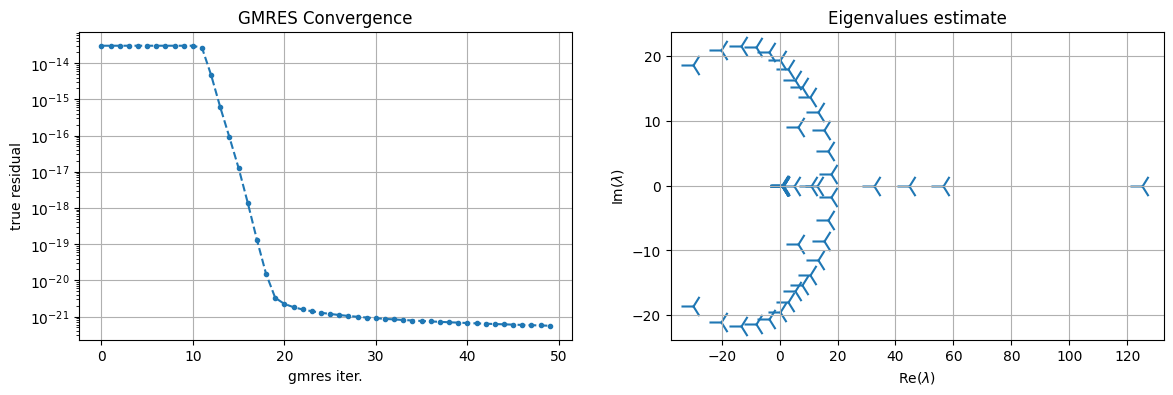

In [51]:
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd


def custom_prec(bmat):
    elim_blocks = [1, 5]
    p_blocks = [0, 2]
    fs = get_fixed_stress_stabilization_nd(model)

    stab = (
        -bmat[p_blocks, elim_blocks].mat
        @ inv_block_diag(J[elim_blocks, elim_blocks].mat, nd=model.nd)
        @ J[elim_blocks, p_blocks].mat
    )
    # stab[:bmat[0, 0].shape[0], :bmat[0,0].shape[1]] = 0
    # stab.eliminate_zeros()

    return fs + stab
    # return stab
    # return fs


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    # invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    invertor=custom_prec,
    invertor_type="physical",
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))